In [2]:
# pip install jyquickhelper
#Le menu s'affiche sur un jupyter notebook

# Sommaire

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Description du projet

### Objectifs du projet



L'objectif principal est de pouvoir prédire le prix journalier d'ouverture ou de fermeture d'une action à partir de données financières des jours antérieurs. Tout en se familiarisant avec le monde de la finance, ce projet est l'occasion pour nous de sonder réellement la plus-value de l'apprentissage automatique pour prédire l'évolution d'un actif financier. Ainsi, il s'agit de comprendre la particularité des séries temporelles traitées pour pouvoir ensuite appliquer le modèle prédictif le plus adéquat. Nous proposons à la toute fin une stratégie simpliste d'achat/vente pour rendre compte de l'intérêt que peuvent apporter de solides prédictions réalisées grâce à l'apprentissage automatique.

### Bases de données utiisées


Dans le cadre de ce projet, nous nous intéressons à la prédiction des actions des GAFAM, et plus particulièrement à Apple. De fait, nous avons exploité toutes les données qui nous paraissaient pertinentes pour cette prédiction, à savoir les données fournies par les cours boursiers des GAFAM, mais aussi les données de l'indicateur de volatilité (VIX) et de l'or (GOLD). Ces deux derniers sont intéressants car la volatilité permet d'expliquer les mouvements brusques des cours et l'or est considéré comme une valeur refuge qui peut possiblement évoluer de manière contraire aux GAFAM lors de crises finanicères.

Pour recueillir les données, nous avons tout d'abord chercher à scraper à la main sur des sites internet. Néanmoins, cette méthode s'avérait peu efficace compte tenu de la multitude d'API déjà existantes. Ainsi, nous avons utilisé les API d'Alphavantage, Tiingo et YahooFinance. Les données présentées ici viennent essentiellement de YahooFinance.

### Méthodologie et modèles

Notre idée consiste à appliquer différentes méthodes de Machine Learning pour sélectionner ensuite la plus performante. Compte tenu de la nature temporelle des données, nous nous attendions à ce que les méthodes de Deep Learning surperforment les méthodes plus classiques d'apprentissage automatique. Néanmoins, il peut être intéressant de tester des méthodes moins élaborées, notamment car ces dernières sont rapides à mettre en place et fournissent un repère pour nos prédictions.

Ainsi, les méthodes utilisées sont : 

1.   Regression Linéaire
2.   Gradient Boosting avec des arbres de décision
3.   MLP
4.   LSTM
5.   SVM pour la classification


L'intérêt des LSTM par rapport aux autres modèles est de posséder une architecture qui permet de se souvenir plus aisément lors de l'apprentissage de données financières anciennes. Dans ce qui suit, nous montrerons essentiellement l'implémentation de cette méthode. Toutefois, nous avons mis en annexe les codes utilisant les autres méthodes.

Pour éviter une surexploitation des données de la veille seulement pour la prédiction, nous prédirons également le delta(différence entre le prix d'aujourd'hui et de la veille) pour voir si les résultats obtenus sont meilleurs.

## Code

## Objectif 1 : Prédire le prix close d'Apple

Dans cette première section nous essayons de prédire le prix de fermeture de l'action Apple. 

### Import des librairies classiques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras

from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Récupération des données

Il y a dans le jupyter "scrap_data.ipynb" différentes méthodes de scrapping, une à la main et d'autres via des API. Nous avons écrit les avantages de chaque méthode. Ici nous retenons la troisième méthode avec la librairie pandas_datareader. 

In [2]:
import pandas_datareader as web
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import pylab

### Définition du dataframe initial

Dans cette section df_gafa_and_vix correspond au dataframe des prix journaliers de fermeture/ouverture/maximum/minimum de l'actions d'Apple/Amazon/Google/Or et de l'indicateur VIX. Ce dataframe sera enrichi de la moyenne mobile plus tard. Nous selectionnerons (via la méthode RFE) aussi les 8 colonnes les plus importantes pour prédire le prix de fermeture d'Apple .

In [3]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('today')

df_web_aapl = web.DataReader('AAPL', data_source='yahoo', start=start, end=end)[:2156]
df_web_aapl.columns = ['High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Close_AAPL', 'Volume_AAPL', 'Adj_Close_AAPL']

df_web_amzn = web.DataReader('AMZN', data_source='yahoo', start=start, end=end)[:2156]
df_web_amzn.columns = ['High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Close_AMZN', 'Volume_AMZN', 'Adj_Close_AMZN']

df_web_googl = web.DataReader('GOOGL', data_source='yahoo', start=start, end=end)[:2156]
df_web_googl.columns = ['High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Close_GOOGL', 'Volume_GOOGL', 'Adj_Close_GOOGL']

df_web_vix = web.DataReader('^VIX', data_source='yahoo', start=start, end=end)[:2156]
df_web_vix.columns = ['High_VIX', 'Low_VIX', 'Open_VIX', 'Close_VIX', 'Volume_VIX', 'Adj_Close_VIX']
df_web_vix = df_web_vix[['High_VIX', 'Low_VIX', 'Open_VIX', 'Close_VIX']]

df_web_gold = web.DataReader('GOLD', data_source='yahoo', start=start, end=end)[:2156]
df_web_gold.columns = ['High_GOLD', 'Low_GOLD', 'Open_GOLD', 'Close_GOLD', 'Volume_GOLD', 'Adj_Close_GOLD']



df_gafa_and_vix =pd.concat([df_web_aapl,df_web_amzn,df_web_gold,df_web_vix], axis=1)  


Nous supprimons les données de l'année 2020 car elles correspondent à la periode de coronavirus. Avant de les supprimer, nous avions des modèles qui avaient beaucoup de mal à prédire Ce qui confirme l'aspect difficilement prédictible de cette période, tout du moins en utilisant de l'apprentissage automatique à partir de données boursières seulement. Dans tout ce qui suit, le 1er janvier 2012 sera pris comme origine de la date.

In [4]:
df_gafa_and_vix = df_gafa_and_vix[:-225]
df_gafa_and_vix = df_gafa_and_vix.reset_index(drop=True)
df_gafa_and_vix.head()

,High_AAPL,Low_AAPL,Open_AAPL,Close_AAPL,Volume_AAPL,Adj_Close_AAPL,High_AMZN,Low_AMZN,Open_AMZN,Close_AMZN,Volume_AMZN,Adj_Close_AMZN,High_GOLD,Low_GOLD,Open_GOLD,Close_GOLD,Volume_GOLD,Adj_Close_GOLD,High_VIX,Low_VIX,Open_VIX,Close_VIX
0,14.732142,14.607142,14.621428,14.686786,302220800.0,12.566676,179.479996,175.550003,175.889999,179.029999,5110800,179.029999,47.770000,46.200001,46.270000,47.509998,9010200.0,41.618229,23.100000,22.540001,22.950001,22.969999
1,14.810000,14.617143,14.642858,14.765715,260022000.0,12.634213,180.500000,176.070007,179.210007,177.509995,4205200,177.509995,48.490002,47.330002,47.480000,48.220001,8905400.0,42.240177,23.730000,22.219999,23.440001,22.219999
2,14.948215,14.738214,14.819643,14.929643,271269600.0,12.774481,178.250000,174.050003,175.940002,177.610001,3809100,177.610001,48.520000,47.419998,47.720001,48.020000,5800800.0,42.064991,23.090000,21.340000,22.750000,21.480000
3,15.098214,14.972143,14.991786,15.085714,318292800.0,12.908023,184.649994,177.500000,178.070007,182.610001,7008400,182.610001,48.299999,47.270000,48.299999,47.540001,4527100.0,41.644520,21.719999,20.580000,21.240000,20.629999
4,15.276786,15.048214,15.196428,15.061786,394024400.0,12.887549,184.369995,177.000000,182.759995,178.559998,5056900,178.559998,48.029999,47.250000,47.720001,47.709999,3958600.0,41.793423,21.780001,21.000000,21.670000,21.070000


In [5]:
len(df_gafa_and_vix)

1931

Nous avons concaténé différents dataframes de différents stocks, il faut donc vérifier qu'il n'y a pas d'incompatibilité entre eux, comme par exemple des jours qui seraient fériers pour un stock et pas pour un autre, auquel cas nous aurions des 'NaN'. 

In [6]:
df_gafa_and_vix.isnull().sum()

High_AAPL         0
Low_AAPL          0
Open_AAPL         0
Close_AAPL        0
Volume_AAPL       0
Adj_Close_AAPL    0
High_AMZN         0
Low_AMZN          0
Open_AMZN         0
Close_AMZN        0
Volume_AMZN       0
Adj_Close_AMZN    0
High_GOLD         0
Low_GOLD          0
Open_GOLD         0
Close_GOLD        0
Volume_GOLD       0
Adj_Close_GOLD    0
High_VIX          0
Low_VIX           0
Open_VIX          0
Close_VIX         0
dtype: int64

df_gafa_and_vix est donc un gros dataframe avec les prix journaliers (close, open, high, low,adj_close) de certains stocks des GAFAM, de l'or et de l'indicateur VIX (l'indicateur de volatilité du marché).

Nous avons intégré le VIX pour la raison suivante. Avant de supprimer les données de la période du coronavirus, nous avions testé des modèles pour prédire le prix journalier de fermeture (le close) d'Apple et nous avions remarqué que le jeu de test était bien différent du jeu de train. En effet, nous n'avions pas mélangé nos données d'entraînement et de test de manière aléatoire pour garder la temporalité de nos données. En conséquence, le jeu de test correspondait également à la période de coronavirus. Il nous a alors semblé pertinent d'ajouter le VIX pour mieux prédire face à la volatilité du marché.

# Statistiques descriptives

Visualisation de la variable à prédire

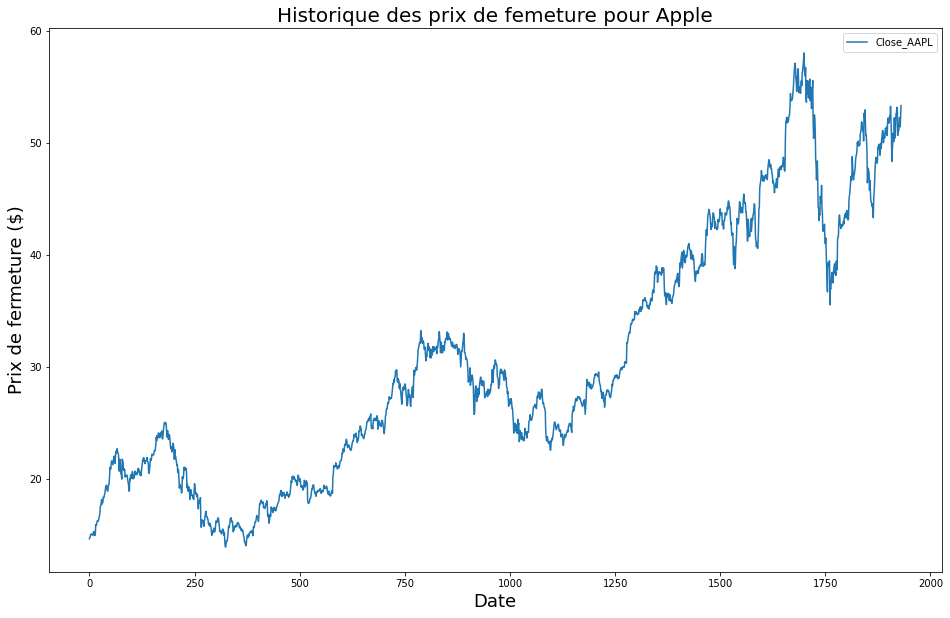

In [7]:
plt.figure(figsize=(16,10))
plt.title('Historique des prix de femeture pour Apple', fontsize=20)
df_gafa_and_vix['Close_AAPL'].plot()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.legend()
plt.show()


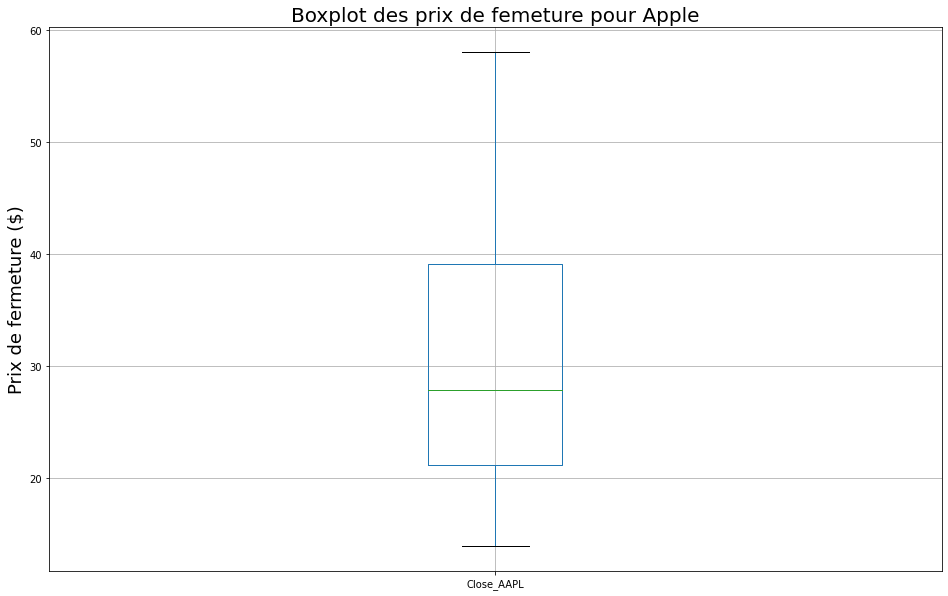

In [8]:
plt.figure(figsize=(16,10))
plt.title('Boxplot des prix de femeture pour Apple', fontsize=20)
df_gafa_and_vix.boxplot(column = 'Close_AAPL')
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.show()

On peut voir sur ce boxplot que la médiane se trouve juste en dessous de 30 dollars, puis que 75% des valeurs sont inférieures à 40 dollars et qu'il n'y a pas à priori de valeurs extrêmes ou abérrantes. On trouve aussi le max et le min qui valent un peu moins de 60 dollars pour l'un et un peu plus de 10 dollars pour l'autre.

In [9]:
df_gafa_and_vix["Close_AAPL"].describe()

count    1931.000000
mean       30.420702
std        11.178842
min        13.947500
25%        21.162500
50%        27.900000
75%        39.102501
max        58.017502
Name: Close_AAPL, dtype: float64

Cette méthode describe() permet de confirmer l'analyse du boxplot et nous donne aussi la valeur moyenne (30.4 dollars) et l'écart type (11.2 dollars).

### Régression linéaire

In [10]:
# Reg
#vecteur cible
XTrain = df_gafa_and_vix[['High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL',
       'Adj_Close_AAPL', 'High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Close_AMZN',
       'Volume_AMZN', 'Adj_Close_AMZN', 'High_GOLD', 'Low_GOLD', 'Open_GOLD',
       'Close_GOLD', 'Volume_GOLD', 'Adj_Close_GOLD', 'High_VIX', 'Low_VIX',
       'Open_VIX', 'Close_VIX']]
yTrain = df_gafa_and_vix[['Close_AAPL']]
#lancer la régression
reg = sm.OLS(yTrain,XTrain)
resReg = reg.fit()

In [11]:
print(resReg.summary())

                                 OLS Regression Results                                
Dep. Variable:             Close_AAPL   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.089e+06
Date:                Tue, 15 Dec 2020   Prob (F-statistic):                        0.00
Time:                        21:11:36   Log-Likelihood:                          1370.8
No. Observations:                1931   AIC:                                     -2702.
Df Residuals:                    1911   BIC:                                     -2590.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

Cette regression linéaire nous donne bien que presque chaque variable, toute chose égale par ailleurs, a un coefficient significativement non nul à un seuil de confiance très élevé (superieur à 95 pourcents et superieur à 99.9 pourcents pour celles dont la pvalue vaut 0.000), exception faite pour le high/open/low/close du Gold pour lesquelles nous ne pouvons pas rejeter à un seuil de confiance de plus de 10% l'hypothèse de nullité des coeficients. Nouns ne pouvons pas non plus rejeter l'hypothèse de nullité du coefficient devant Open_VIX.

Vérifions donc avec un test de Fisher si ces variables peuvent être conjointement non significatives à un certain seuil de confiance : 

In [12]:
#'High_AAPL','Close_AAPL', 'Low_AAPL', 'Open_AAPL', 'Adj_Close_AAPL', 'Close_GOLD', 'Close_VIX'
hypotheses = '(Open_GOLD = 0), (Close_GOLD=0), (Low_GOLD = 0), (High_GOLD=0)'
f_test = resReg.f_test(hypotheses)
print(f_test)

<F test: F=array([[5.23044475]]), p=0.00034394315063746765, df_denom=1.91e+03, df_num=4>


Grâce à ce test de Fisher, nous pouvons rejeter l'hyothèse de nullité jointe des variables high/open/low/close du Gold au seuil de 99%.

### Sélection de variables

Etant donné un estimateur qui assigne un poids aux variables (ici les coefficients de la regression lineaire), le but de la RFE est de sélectionner les variables en considérant récursivement des ensembles de plus en plus petits de variables. Ceci est fait en retirant successivement la variable (feature) de poids le plus faible.

In [13]:

XTrain = df_gafa_and_vix[['High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL', 'Adj_Close_AAPL','High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Close_AMZN', 'Volume_AMZN','Adj_Close_AMZN','High_GOLD', 'Low_GOLD', 'Open_GOLD', 'Close_GOLD', 'Volume_GOLD', 'Adj_Close_GOLD', 'High_VIX', 'Low_VIX', 'Open_VIX', 'Close_VIX']]
yTrain = df_gafa_and_vix[['Close_AAPL']]

model = LinearRegression()
rfe = RFE(model, 7)
X_rfe = rfe.fit_transform(XTrain,yTrain)  
model.fit(X_rfe,yTrain)
#print(rfe.support_)
print(rfe.ranking_)
#print(XTrain.shape)

[ 1  1  1 15  1  9  6 11  8 14  7  4  5 12  1 13  1  2  3 10  1]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Résultats de la sélection

Comme attendu, les informations concernants APPLE sont toutes retenues sauf le volume journalier, mais aussi la valeur de l'indice de volatilité à la fermeture et le cours de l'or à la fermeture.

Nous construisons donc le nouveau dataframe :

In [14]:
df_train_rfe_et_close = df_gafa_and_vix[['High_AAPL','Close_AAPL', 'Low_AAPL', 'Open_AAPL', 'Adj_Close_AAPL', 'Close_GOLD', 'Close_VIX']]

#### Moyenne mobile

La moyenne mobile exponentielle (EMA) est une moyenne mobile pondérée dans le temps. Par cette pondération, elle accorde plus de poids aux prix de clôture les plus récents, et moins aux prix de clôture les plus anciens. L'EMA est très utilisée par les traders car c'est un bon indicateur de tendance. Nous avons choisi de prendre en compte les cinquante derniers jours pour avoir un suivi de tendance assez lisse. L'intérêt de l'incorporer dans nos données est d'éviter un surapprentissage dans des configurations assez volatiles et brusques qui seraient soudaines et contraires à la tendance générale. L'idée derrière est de permettre à l'algorithme de plus facilement garder en mémoire la tendance passée pour prédire le prix du lendemain.  

In [15]:
# Création de la moyenne mobile exponentielle
df_stock = df_train_rfe_et_close['Close_AAPL']
ema = pd.Series.ewm(df_stock, span=50).mean()
dataset_ema = np.reshape(ema.values,(len(ema),1))
ema.values

array([14.6867857 , 14.72703946, 14.79729289, ..., 50.86542512,
       50.92158494, 51.01564042])

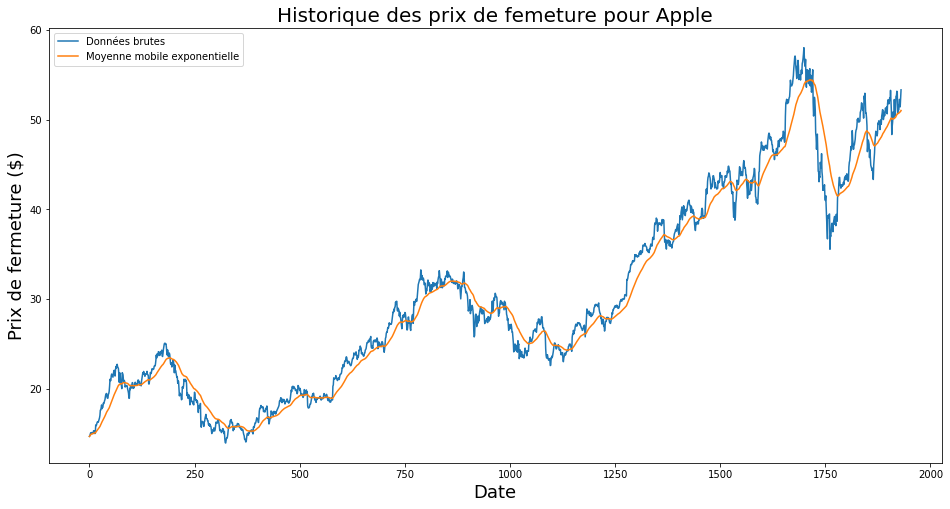

In [16]:
# Visualisation des prix de fermeture
plt.figure(figsize=(16,8))
plt.title('Historique des prix de femeture pour Apple', fontsize=20)
plt.plot(df_stock)
plt.plot(ema)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de fermeture ($)', fontsize=18)
plt.legend(['Données brutes','Moyenne mobile exponentielle'])
plt.show()

Nous ajoutons la moyenne mobile à notre dataframe :

In [17]:
df_train_rfe_et_close["moyenne_mobile"] = dataset_ema

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_train_rfe_et_close.head()

,High_AAPL,Close_AAPL,Low_AAPL,Open_AAPL,Adj_Close_AAPL,Close_GOLD,Close_VIX,moyenne_mobile
0,14.732142,14.686786,14.607142,14.621428,12.566676,47.509998,22.969999,14.686786
1,14.810000,14.765715,14.617143,14.642858,12.634213,48.220001,22.219999,14.727039
2,14.948215,14.929643,14.738214,14.819643,12.774481,48.020000,21.480000,14.797293
3,15.098214,15.085714,14.972143,14.991786,12.908023,47.540001,20.629999,14.873781
4,15.276786,15.061786,15.048214,15.196428,12.887549,47.709999,21.070000,14.914449


### Définition de Delta

Pour la suite, nous définissons un dataframe df avec les valeurs des deltas.

In [20]:
dt = (df_gafa_and_vix[["Close_AAPL"]].reset_index(drop=True))


yesterday_close_aapl = dt['Close_AAPL'].shift(1)

df_train_rfe_et_close["yesterday_close_AAPL"] = yesterday_close_aapl
df_train_rfe_et_close["delta"] = df_train_rfe_et_close["Close_AAPL"]-df_train_rfe_et_close["yesterday_close_AAPL"]

indice_nan = [0]
df_train_rfe_et_close.drop(indice_nan, 0, inplace = True)


df_train_rfe_et_close.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

,High_AAPL,Close_AAPL,Low_AAPL,Open_AAPL,Adj_Close_AAPL,Close_GOLD,Close_VIX,moyenne_mobile,yesterday_close_AAPL,delta
1,14.810000,14.765715,14.617143,14.642858,12.634213,48.220001,22.219999,14.727039,14.686786,0.078929
2,14.948215,14.929643,14.738214,14.819643,12.774481,48.020000,21.480000,14.797293,14.765715,0.163928
3,15.098214,15.085714,14.972143,14.991786,12.908023,47.540001,20.629999,14.873781,14.929643,0.156072
4,15.276786,15.061786,15.048214,15.196428,12.887549,47.709999,21.070000,14.914449,15.085714,-0.023929
5,15.214286,15.115714,15.053572,15.211071,12.933691,48.330002,20.690001,14.951435,15.061786,0.053928


*Nous utiliserons df pour la section 2 avec la prediction de delta*

In [21]:
df = df_train_rfe_et_close.copy()


### y_naif

Nous définissons une baseline qui consiste à prédire le prix de la veille pour le lendemain. Nous avons normalisé et nous obtenons la variable normalized_col_naif.

In [22]:
y_naif = df["yesterday_close_AAPL"].to_numpy()

data_stock_naif = df.filter(['yesterday_close_AAPL'])
dataset_stock_naif = data_stock_naif.values
scaler_stock_close_naif = MinMaxScaler(feature_range=(0,1))
normalized_col_naif = scaler_stock_close_naif.fit_transform(dataset_stock_naif)


### Preprocessing

Il est nécessaire d'effectuer un pré-processing des données pour avoir la même echelle. L'idée est de ne pas donner plus de poids à une variable à cause de son unité de mesure ou plus généralement à cause de son echelle. Par exemple si on avait certaines données en centimes de dollars et d'autres en dollars ça pourrait induire le modèle en erreur. 

Pour cela nous pouvons normaliser ou standardiser nos données. La standardisation se fait sur des données dont la distribution approche celle d'une loi normale en général et consiste à centrer puis réduire la variable. Normaliser consiste à prendre le rapport entre la différence entre la variable et son minimum sur la différence entre son maximum et son minimum. On obtient des valeurs entre 0 et 1.

In [23]:
def normalize_min_max(df, col):
    """
    Retourne : 
      Un array normalisée par la méthode Min Max de la colonne col du dataframe df

    Parametres d'entrées : 
      df : DataFrame  -> le dataframe des données 
      col : string    -> la colonne à normaliser
    
    """
    data = df.filter([col])
    dataset = data.values
    scaler = MinMaxScaler(feature_range=(0,1))
    normalized_col = scaler.fit_transform(dataset)
    
    return normalized_col, scaler


In [24]:
#Normalisation des données

## Pour le close on a besoin de garder en variable globale le feature_range=(0,1)
data_close = df_train_rfe_et_close.filter(['Close_AAPL'])
dataset_close = data_close.values
scaler_stock_close = MinMaxScaler(feature_range=(0,1))
normalized_close = scaler_stock_close.fit_transform(dataset_close)

scaled_close, scaler_close = normalize_min_max(df_train_rfe_et_close,'Close_AAPL')
scaled_open, scaler_open = normalize_min_max(df_train_rfe_et_close,'Open_AAPL')
scaled_adj, scaler_adj = normalize_min_max(df_train_rfe_et_close,'Adj_Close_AAPL')
scaled_high, scaler_high = normalize_min_max(df_train_rfe_et_close,'High_AAPL')
scaled_low, scaler_low = normalize_min_max(df_train_rfe_et_close,'Low_AAPL')
scaled_close_gold, scaler_close_gold = normalize_min_max(df_train_rfe_et_close,'Close_GOLD')
scaled_vix, scaler_vix = normalize_min_max(df_train_rfe_et_close,'Close_VIX')
scaled_ma, scaler_ma = normalize_min_max(df_train_rfe_et_close,'moyenne_mobile')

scaled_data=np.concatenate((scaled_close, scaled_open, scaled_adj, scaled_high, scaled_low, scaled_close_gold, scaled_vix, scaled_ma),axis=1)

In [25]:
scaled_data.shape

(1930, 8)

In [26]:
type(scaler_close)

sklearn.preprocessing._data.MinMaxScaler

### Découpage des données en jeux de train et de test

In [27]:
#la proportion des données d'entrainement
prop_train_size= 0.7
# le nombre de variables explicatives
nb_columns = 8
# la taille des fenetres d'entrainement
time_step = 16
# la taille du jeu d'entrainement
training_data_len = int(len(df_train_rfe_et_close) * prop_train_size)

In [28]:
array_output = df_stock.values

In [29]:
def split_data(array_input, array_output, naif, prop_train_size, nb_columns):
    """
    Retourne : 
      Split le jeu de données en train, test à la fois pour les input, pour l'output, et pour la stratégie naive. L'ordre est conservé. 
    
    Parametres d'entrées :
      array_input : np.array  -> jeu de données d'input
      array_output : np.array -> jeu de données d'output
      naif : np.array         -> jeu de données naif
      prop_train_size : float -> proportion du jeu d'entrainement
      nb_columns : int        -> nombre de features 
    
    """    
    n = len(array_output)
    training_size = int(n*prop_train_size)
    test_size = n- training_size
    
    array_split_input_train= array_input[:training_size].reshape(-1,nb_columns)
    array_split_input_test = array_input[training_size:].reshape(-1,nb_columns)
    
    array_split_output_train = array_output[:training_size].reshape(-1,1)
    array_split_output_test = array_output[training_size:].reshape(-1,1)

    array_naif_train =  naif[:training_size].reshape(-1,1)
    array_naif_test = naif[training_size:].reshape(-1,1)
    
    return array_split_input_train, array_split_input_test, array_split_output_train, array_split_output_test, array_naif_train, array_naif_test

def create_windows_data_XandY(array_split_input, array_split_output, time_step, array_naif ):
    """
    Retourne : Jeux de données train,test et naif avec des fenetres flissantes de taille time_step
      
    
    Parametres d'entrées :
      array_split_input : np.array          -> jeu de donnée d'input, idéalement un des deux sorti par la fonction split_data
      array_split_output : np.array         -> jeu de donnée d'output, idéalement celui sorti par la fonction split_data
      time_step : int                       ->
      array_naif : np.array                 ->

    """
    dataX = []
    dataY = []
    y_naif = []
    
    for i in range(len(array_split_output)- time_step - 1) : 
        set_value = array_split_input[i : (i+time_step) ,:]
        dataX.append(set_value)
        dataY.append(array_split_output[i + time_step])
        y_naif.append(array_naif[i + time_step])

    return np.array(dataX), np.array(dataY), np.array(y_naif)



In [30]:
train_data_input, test_data_input ,train_data_output, test_data_output, naif_train, naif_test = split_data(scaled_data, scaled_close, normalized_col_naif, prop_train_size, nb_columns)
X_train, Y_train, naif_train_windows= create_windows_data_XandY(train_data_input, train_data_output, time_step, naif_train)
X_test, Y_test , naif_test_windows= create_windows_data_XandY(test_data_input, test_data_output, time_step, naif_test)

In [31]:
print(train_data_input.shape)
print(test_data_input.shape)
print(type(train_data_input))
print(type(test_data_input))

print(train_data_output.shape)
print(test_data_output.shape)
print(type(train_data_output))
print(type(test_data_output))

(1351, 8)
(579, 8)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1351, 1)
(579, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(X_train.shape)
print(Y_train.shape)

(1334, 16, 8)
(1334, 1)


### Définition des modèles

Il y a beaucoup d'hyperparamètres dans ce modèle. Mis a part les hyperparamètres classiques (learning rate, fonctions d'activation, fonctions de coût, nombre de couches cachées, nombre de neurones par couche, la taille des batches..), nous avons aussi le nombre de jour de la fenêtre glissante (time_step) qui détient un role important.

Nous avions eu au départ beaucoup d'overfitting, et le modèle ne semblait pas du tout apprendre (le graph des fonctions de coût du train et de la validation donnait systématiquement deux droites presque parrallèles et très eloignées). Dans un tel cas où le modèle n'apprend pas, nous avons décidé de modifier les paramètres par défaut de l'optimiser Adam pour sélectionner un learning rate idéal. En effet celui par défaut était trop grand (de l'ordre de  1e-2) et nous avons finalement choisi un learning rate de l'ordre de 1e-4. Suite à ce choix, la courbe de la loss validation commençait enfin à décroitre ! Première victoire mais cependant, la courbe de la loss du train restait constante. Nous avions donc de l'overfitting. Pour cela nous avons ajouté deux couches de Dropout de probabilité 0.2, et nous avons diminué le nombre de jour de la fenêtre à 32. Nous obtenons enfin un modèle cohérent (mais encore loin d'être parfait). Il faut bien sûr ajouter à cela la difficulté de prédire le cours d'une action même hors coronavirus et la faible quantité des données.

#### Modèle 1 : batch_size = 16

In [32]:
model = Sequential()


model.add(LSTM(64, return_sequences=False,input_shape=(time_step,nb_columns)))
model.add(Dropout(0.2))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(1, activation = "linear"))




In [33]:
#Optimizer Adam modifié 
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2 = 0.999, epsilon =1e-8)

#Compilation
model.compile(optimizer=adam, loss='mean_squared_error', metrics = ["mae"])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18688     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 22,913
Trainable params: 22,913
Non-trainable params: 0
_________________________________________________________________


#### Phase d'apprentissage

In [ ]:
model.fit(X_train, Y_train, validation_data = (X_test, Y_test),  verbose=1)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),  epochs = 200, batch_size=16)

42/42 [==============================] - 1s 14ms/step - loss: 0.0196 - mae: 0.1080 - val_loss: 0.0613 - val_mae: 0.2337
Epoch 1/200
84/84 [==============================] - 0s 5ms/step - loss: 0.0049 - mae: 0.0543 - val_loss: 0.0086 - val_mae: 0.0785
Epoch 2/200
84/84 [==============================] - 0s 5ms/step - loss: 0.0034 - mae: 0.0452 - val_loss: 0.0109 - val_mae: 0.0906
Epoch 3/200
84/84 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0421 - val_loss: 0.0049 - val_mae: 0.0580
Epoch 4/200
84/84 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0389 - val_loss: 0.0045 - val_mae: 0.0557
Epoch 5/200
84/84 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0367 - val_loss: 0.0055 - val_mae: 0.0627
Epoch 6/200
84/84 [==============================] - 0s 4ms/step - loss: 0.0022 - mae: 0.0350 - val_loss: 0.0042 - val_mae: 0.0539
Epoch 7/200
84/84 [==============================] - 0s 5ms/step - loss: 0.0021 - mae: 0.0344 

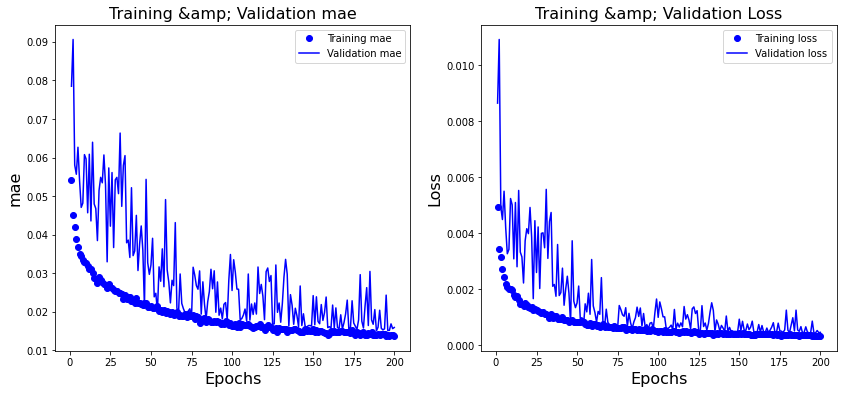

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(epochs, mae, 'bo', label='Training mae')
ax[0].plot(epochs, val_mae, 'b', label='Validation mae')
ax[0].set_title('Training &amp; Validation mae', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('mae', fontsize=16)
ax[0].legend()
 
ax[1].plot(epochs, loss_values, 'bo', label='Training loss') 
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training &amp; Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

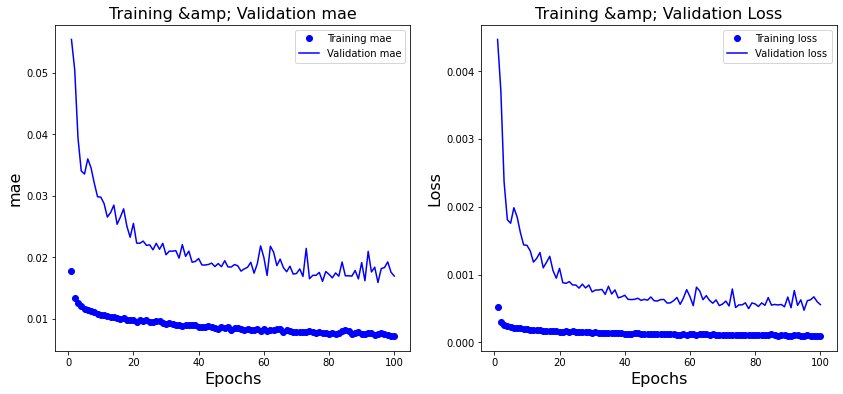

In [ ]:
# Exemple de graph des loss initiales Après modification du learning rate mais avant l'insertion des Dropouts on avait un modèle dont la loss d'entrainement était presque constante

#### Modele 2 batch_size = 4

In [38]:
model2 = Sequential()


model2.add(LSTM(64, return_sequences=False,input_shape=(time_step,nb_columns)))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation = "relu"))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation = "linear"))

#optimizer
adam2 = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2 = 0.999, epsilon =1e-8)

#compilation
model2.compile(optimizer=adam2, loss='mean_squared_error', metrics = ["mae"])

model2.summary()

model2.fit(X_train, Y_train, validation_data = (X_test, Y_test),  verbose=1)
history2 = model2.fit(X_train, Y_train, validation_data=(X_test, Y_test),  epochs = 200, batch_size=4)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18688     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 22,913
Trainable params: 22,913
Non-trainable params: 0
_________________________________________________________________
42/42 [==============================] - 1s 14ms/step - loss: 0.0505 - mae: 0.1801 - val_loss: 0.0339 - val_mae: 0.1

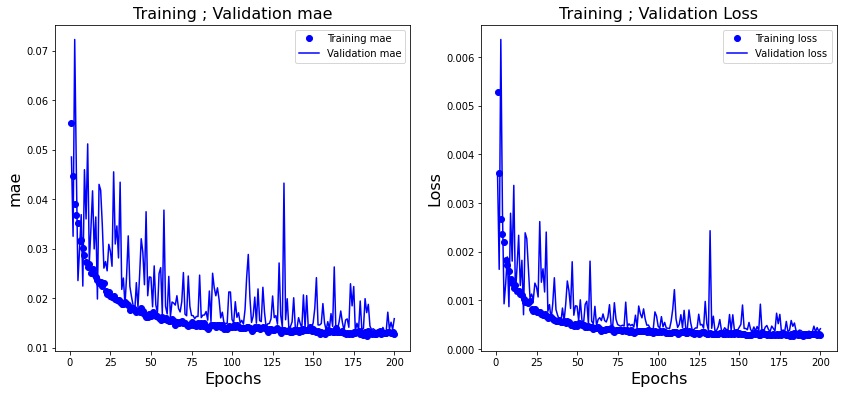

In [39]:

#time_step = 16 / 200epochs / 64/64 batch_size = 4

history_dict2 = history2.history
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
mae2 = history_dict2['mae']
val_mae2 = history_dict2['val_mae']
 
epochs2 = range(1, len(loss_values2) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(epochs2, mae2, 'bo', label='Training mae')
ax[0].plot(epochs2, val_mae2, 'b', label='Validation mae')
ax[0].set_title('Training ; Validation mae', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('mae', fontsize=16)
ax[0].legend()
 
ax[1].plot(epochs, loss_values2, 'bo', label='Training loss') 
ax[1].plot(epochs, val_loss_values2, 'b', label='Validation loss')
ax[1].set_title('Training ; Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

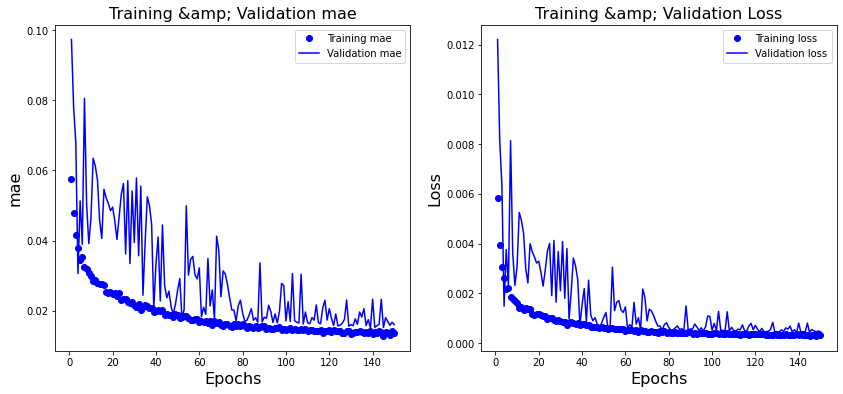

In [ ]:
#time step = 64 et 200 epochs

### Prédiction

In [ ]:
prediction_test_scaled = model.predict(X_test)
prediction_train_scaled = model.predict(X_train)


In [ ]:
prediction_test_scaled2 = model2.predict(X_test)
prediction_train_scaled2 = model2.predict(X_train)


Nous effectuons la transformation inverse du Min Max scaler du close :

In [ ]:
prediction_test = scaler_stock_close.inverse_transform(prediction_test_scaled)
prediction_train = scaler_stock_close.inverse_transform(prediction_train_scaled)

In [ ]:
prediction_test2 = scaler_stock_close.inverse_transform(prediction_test_scaled2)
prediction_train2 = scaler_stock_close.inverse_transform(prediction_train_scaled2)

In [ ]:
test = scaler_stock_close.inverse_transform(Y_test)
train = scaler_stock_close.inverse_transform(Y_train)

naif_test_transform = scaler_stock_close_naif.inverse_transform(naif_test_windows)

### Mesure de la performance

Dans ce modèle nous essayons de prédire le prix journalier de fermeture de l'action d'Apple. Nous reprenons la prédiction naïve y_naif qui consiste à prédire pour le jour j, le prix du jour j-1. Nous considérons cette prédiction comme notre baseline et nous tentons de faire mieux.

In [ ]:
print("L'erreur moyenne (MSE) de prédiction du modèle à 200 epochs, batch_size = 16 est de : " + str(np.sqrt(mean_squared_error(test,prediction_test))) + " $ par jour ")

print("L'erreur moyenne (MSE) de prédiction du modèle à 200 epochs, batch_size = 4 est de : " + str(np.sqrt(mean_squared_error(test,prediction_test2))) + " $ par jour ")

print("L'erreur moyenne (MSE) de prédiction du modèle naif est de : " + str(np.sqrt(mean_squared_error(test,naif_test_transform))) + " $ par jour ")

L'erreur moyenne (MSE) de prédiction du modèle à 200 epochs, batch_size =16 est de : 0.9360897421504242 $ par jour
L'erreur moyenne (MSE) de prédiction du modèle à 200 epochs, batch_size =4 est de : 0.8039968177041982 $ par jour
L'erreur moyenne (MSE) de prédiction du modèle naif est de : 0.7667010058173364 $ par jour 


Nous ne faisons donc pas mieux que le modèle naïf. Une possibilité est d'utiliser du NLP pour avoir des informations pertinentes. De plus le cours d'Apple hors coronavirus est assez continue, le modèle naïf semble être donc particulièrement proche de la réalité, comme le montre le graphique suivant. 

### Affichage

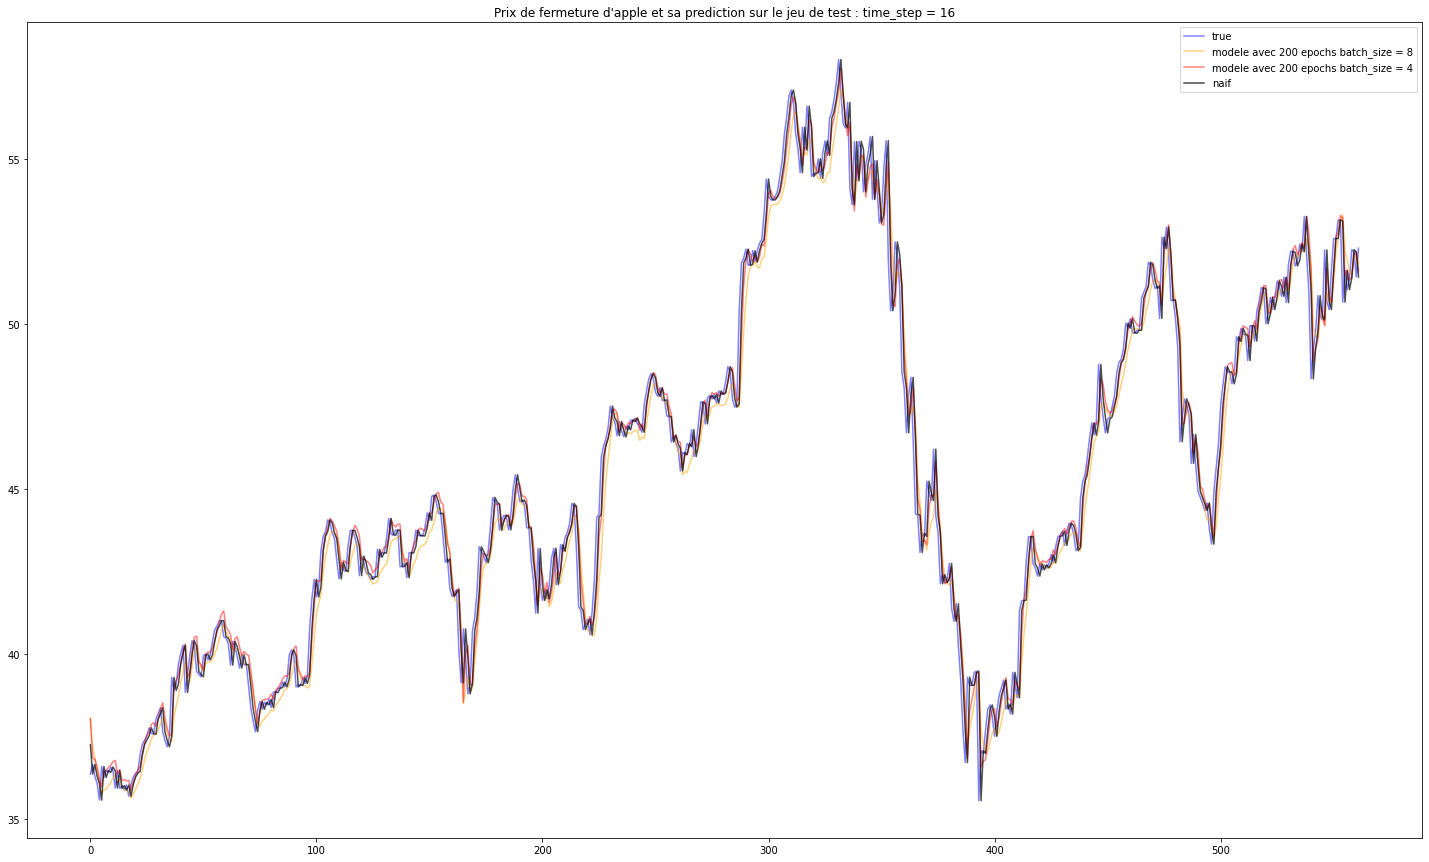

In [ ]:
plt.figure(figsize=(25,15))
plt.title("Prix de fermeture d'apple et sa prediction sur le jeu de test : time_step = 16")
plt.plot(test, color = "blue", label = 'true', alpha = 0.5)
plt.plot(prediction_test, color = "orange",label = 'modele avec 200 epochs batch_size = 8', alpha =0.5) #modèle 1 
plt.plot(prediction_test2, color = "red", label = 'modele avec 200 epochs batch_size = 4', alpha =0.5) #modèle 2

plt.plot(naif_test_transform, color = "black",label = 'naif', alpha =0.7)
plt.legend()
plt.show()

On voit que le modèle 2 et naif sont très proches (en effet leur différence est de 0.03 dollars par jours en moyenne

### Il y a en annexe dans le github dans le fichier Presentation (à cette adresse https://github.com/lanfeustX/MLTRADING/tree/main/Pr%C3%A9sentation ) d'autres jupyter notebook avec des méthodes plus classiques que les LSTM, comme la régression linéaire, le gradient boosting et les MLP pour prédire le prix close d'Apple.

Il était prévisible que le Gradient Boosting ne soit pas du tout approprié car il est borné. En effet on le confirme sur le graph de prédiction du jeu de test qu'il ne dépasse pas la valeur maximal qu'il a apprit sur des données du jeu de train.

## Objectif 2 : Prédire le delta

Contrairement à la section 1 où nous avons utilisé l'information des closes précédents pour prédire le close suivant, l'objectif initial de la section 2 était d'essayer de prédire un output sans le donner en input, pour éviter l'overfitting.

Nous avons défini plus haut un dataframe df, avec la variable delta qui correspond tout simplement à la différence entre le prix du jour courrant avec le prix de la veille. Nous avons donc les mêmes inputs mais nous voulons prédire une nouvelle variable : le delta.

In [ ]:
df.head()

,High_AAPL,Close_AAPL,Low_AAPL,Open_AAPL,Adj_Close_AAPL,Close_GOLD,Close_VIX,moyenne_mobile,yesterday_close_AAPL,delta
1,14.810000,14.765715,14.617143,14.642858,12.634213,48.220001,22.219999,14.727039,14.686786,0.078929
2,14.948215,14.929643,14.738214,14.819643,12.774481,48.020000,21.480000,14.797293,14.765715,0.163928
3,15.098214,15.085714,14.972143,14.991786,12.908023,47.540001,20.629999,14.873781,14.929643,0.156072
4,15.276786,15.061786,15.048214,15.196428,12.887549,47.709999,21.070000,14.914449,15.085714,-0.023929
5,15.214286,15.115714,15.053572,15.211071,12.933691,48.330002,20.690001,14.951435,15.061786,0.053928


In [ ]:
df_output = (df['delta'])
array_output = df_output.to_numpy()
array_output.reshape(-1)

array([ 0.07892895,  0.16392803,  0.15607166, ..., -0.76000214,
        0.87250137,  1.02249908])

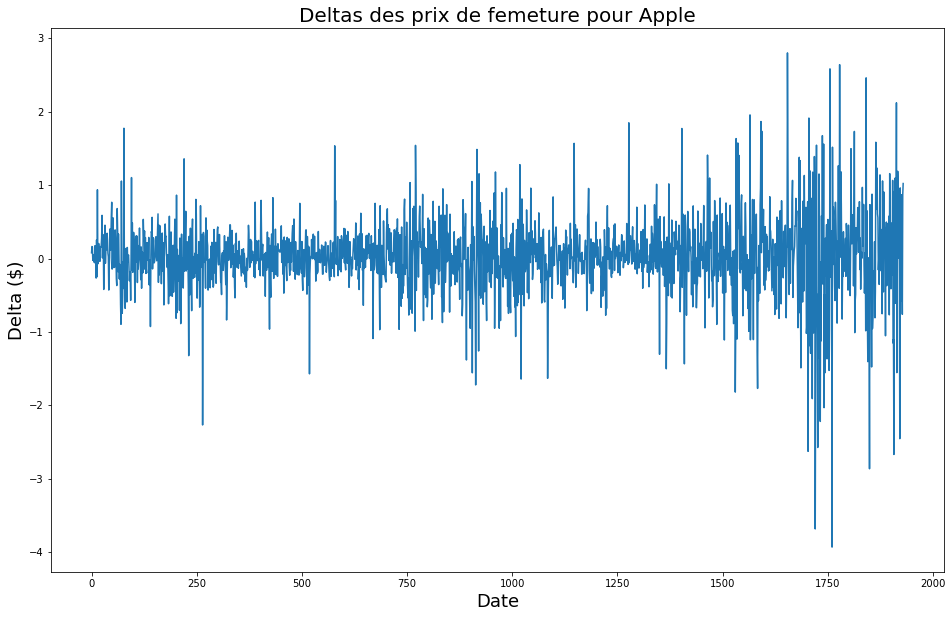

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Deltas des prix de femeture pour Apple', fontsize=20)
plt.plot(array_output)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Delta ($)', fontsize=18)          
plt.show()

Distribution des Deltas

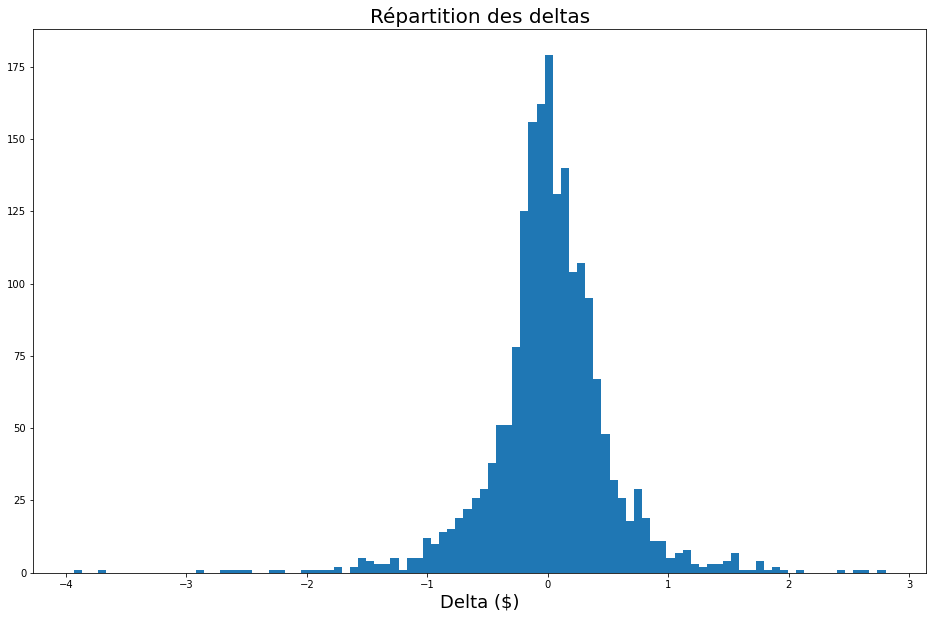

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Répartition des deltas', fontsize=20)
plt.xlabel('Delta ($)', fontsize=18)
plt.hist(array_output, bins=100)
plt.show()

A ce stade, il n'est pas impensable que la distribution des deltas s'approche d'une loi gaussienne

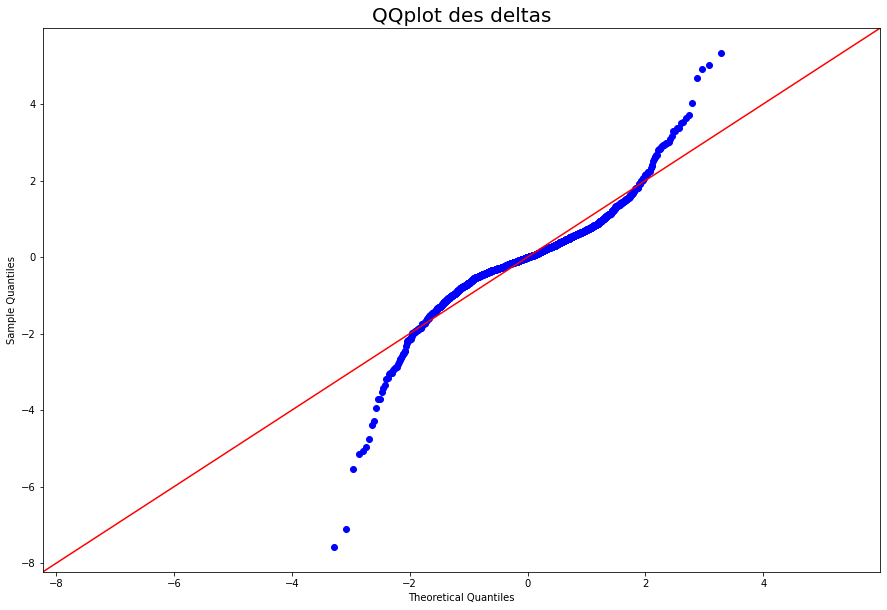

In [ ]:
sm.qqplot( (df.delta- df.delta.mean())/df.delta.std(), line='45')
plt.gcf().set_size_inches(15, 10)
plt.title('QQplot des deltas', fontsize=20)
pylab.show()

Le QQ-plot donne encore une impression d'une distribution proche de la loi Normale(0,1)

In [ ]:
df.delta.kurtosis()

7.274773583618242

Cependant le Kurtosis est plus grand que le seuil d'acceptation qui vaut 3. Nous ne supposons donc pas que la distribution des deltas approche celle d'une loi Normale centrée et réduite.

L'hypothèse de Normalité des deltas n'étant pas retenue, nous ne standardisons pas les données en les centrant puis réduisant mais nous les normalisons avec la méthode Min Max.

In [ ]:
data_delta = df.filter(['Close_AAPL'])
dataset_delta = data_delta.values
scaler_delta = MinMaxScaler(feature_range=(0,1))
normalized_col_delta = scaler_delta.fit_transform(dataset_delta)

In [ ]:
normalized_col_delta.shape

(1930, 1)

In [ ]:
def split_data_delta(array_input, array_output,cprop_train_size, nb_columns):
    """
    Retourne : 
      Split le jeu de données en train, test à la fois pour les input, pour l'output. L'ordre est conservé. 
    
    Parametres d'entrées :
      array_input : np.array  -> jeu de données d'input
      array_output : np.array -> jeu de données d'output
      prop_train_size : float -> proportion du jeu d'entrainement
      nb_columns : int        -> nombre de features 
    
    """

    n = len(array_output)
    training_size = int(n*prop_train_size)
    test_size = n- training_size
    
    array_split_train_input = array_input[:training_size].reshape(-1,nb_columns)
    array_split_test_input = array_input[training_size:].reshape(-1,nb_columns)
    
    array_split_train_output = array_output[:training_size].reshape(-1,1)
    array_split_test_output = array_output[training_size:].reshape(-1,1)

    
    return array_split_train_input , array_split_test_input, array_split_train_output, array_split_test_output

def create_windows_data_XandY_delta(array_split_input, array_split_output, time_step ):
    """
    Retourne : Jeux de données train,test et naif avec des fenetres flissantes de taille time_step
      
    
    Parametres d'entrées :
      array_split_input : np.array          -> jeu de donnée d'input, idéalement un des deux sorti par la fonction split_data
      array_split_output : np.array         -> jeu de donnée d'output, idéalement celui sorti par la fonction split_data
      time_step : int                       -> nombre de jour dans la fenetre glissante

    """
    dataX = []
    dataY = []
    
    for i in range(len(array_split_output)- time_step - 1) : 
        set_value = array_split_input[i : (i+time_step) ,:]
        dataX.append(set_value)
        dataY.append(array_split_output[i + time_step])
        
    return np.array(dataX), np.array(dataY)


In [ ]:
train_data_input_delta, test_data_input_delta ,train_data_output_delta, test_data_output_delta = split_data_delta(scaled_data, normalized_col_delta, prop_train_size, nb_columns)
X_train_delta, Y_train_delta= create_windows_data_XandY_delta(train_data_input_delta, train_data_output_delta, time_step)
X_test_delta, Y_test_delta = create_windows_data_XandY_delta(test_data_input_delta, test_data_output_delta, time_step)

### Modèle de prédiction du delta

In [ ]:
model_delta = Sequential()


model_delta.add(LSTM(64, return_sequences=False,input_shape=(time_step,nb_columns)))
model_delta.add(Dropout(0.2))
model_delta.add(Dense(64, activation = "relu"))
model_delta.add(Dropout(0.2))
model_delta.add(Dense(1, activation = "linear"))

adam_delta = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2 = 0.999, epsilon =1e-8)
model_delta.compile(optimizer=adam_delta, loss='mean_squared_error', metrics = ["mae"])

model_delta.summary()

model_delta.fit(X_train_delta, Y_train_delta, validation_data = (X_test_delta, Y_test_delta),  verbose=1)
history_delta = model_delta.fit(X_train_delta, Y_train_delta, validation_data=(X_test_delta, Y_test_delta),  epochs = 200, batch_size=8)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 64)                18688     
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 22,913
Trainable params: 22,913
Non-trainable params: 0
_________________________________________________________________
42/42 [==============================] - 1s 14ms/step - loss: 0.0237 - mae: 0.1173 - val_loss: 0.0585 - val_mae: 0.

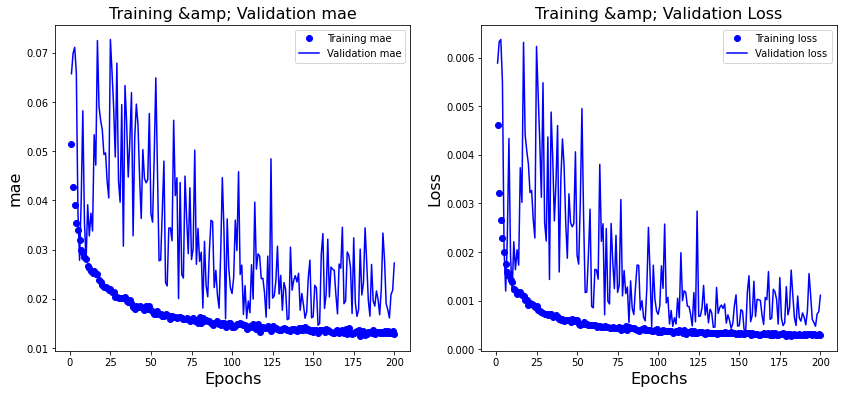

In [ ]:
history_dict_delta = history_delta.history
loss_values_delta = history_dict_delta['loss']
val_loss_values_delta = history_dict_delta['val_loss']
mae_delta = history_dict_delta['mae']
val_mae_delta = history_dict_delta['val_mae']
 
epochs = range(1, len(loss_values_delta) + 1)
fig_delta, ax_delta = plt.subplots(1, 2, figsize=(14, 6))

ax_delta[0].plot(epochs, mae_delta, 'bo', label='Training mae')
ax_delta[0].plot(epochs, val_mae_delta, 'b', label='Validation mae')
ax_delta[0].set_title('Training &amp; Validation mae', fontsize=16)
ax_delta[0].set_xlabel('Epochs', fontsize=16)
ax_delta[0].set_ylabel('mae', fontsize=16)
ax_delta[0].legend()
 
ax_delta[1].plot(epochs, loss_values_delta, 'bo', label='Training loss') 
ax_delta[1].plot(epochs, val_loss_values_delta, 'b', label='Validation loss')
ax_delta[1].set_title('Training &amp; Validation Loss', fontsize=16)
ax_delta[1].set_xlabel('Epochs', fontsize=16)
ax_delta[1].set_ylabel('Loss', fontsize=16)
ax_delta[1].legend()

In [ ]:
train_predict_delta = model.predict(X_train_delta)
test_predict_delta = model.predict(X_test_delta)

In [ ]:
delta_inverse = scaler_delta.inverse_transform(test_predict_delta)

La distribution de ce qui à été prédit sur les valeurs réelles :

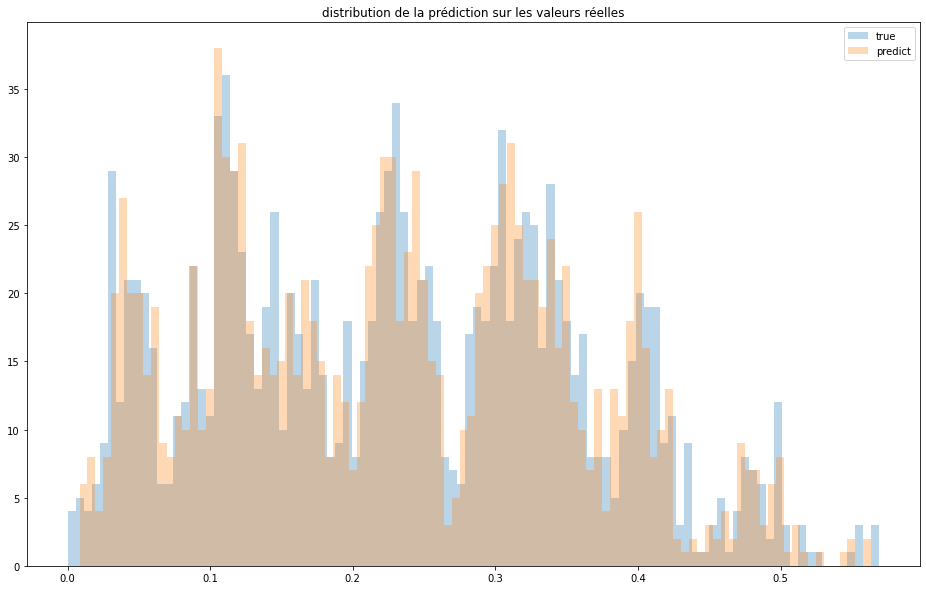

In [ ]:
plt.figure(figsize=(16,10))
plt.title('distribution de la prédiction sur les valeurs réelles')
plt.hist(Y_train_delta.reshape(-1), bins = 100, label = "true", alpha =0.3)
plt.hist(train_predict_delta.reshape(-1), bins = 100, label = "predict", alpha=0.3)
plt.legend()
plt.show()

### Score final delta

In [ ]:

print("L'erreur moyenne (MSE) de prédiction du modèle à 200 epochs, batch_size = 8 est de : " + str(np.sqrt(mean_squared_error(Y_test_delta,test_predict_delta))) + " $ par jour ")
print("L'erreur moyenne (MSE) de prédiction du modèle naif (qui consite en la moyenne des delta) est de : " + str(np.sqrt(mean_squared_error(Y_test_delta,np.ones(len(Y_test_delta))*Y_train_delta.mean()))) +" $ par jour")


L'erreur moyenne (MSE) de prédiction du modèle à 200 epochs, batch_size = 8 est de : 0.02124096813622071 $ par jour 
L'erreur moyenne (MSE) de prédiction du modèle naif (qui consite en la moyenne des delta) est de : 0.4960670491126734 $ par jour


Nous faisons mieux que la moyenne, même sur cette distribution qui semble assez symétrique.

## Objectif 3 : **Classifier** par rapport au delta

Nous avons voulu également prévoir le signe "delta", différence de prix du close Apple d'un jour à l'autre, plutôt que les deltas eux-mêmes, ce qui peut être une idée efficace pour une stratégie. 
Comme nous voulons prédire deux classes: soit une augmentation du close, soit une diminution, nous devons utiliser un algorithme de classification. Nous avons deux classes, donc notre idée est d'utiliser un support vector classifier.

### Import des librairies de la section

In [44]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


In [45]:
df["class"] = np.where(df["delta"]>0,1,-1)
df.head()

,High_AAPL,Close_AAPL,Low_AAPL,Open_AAPL,Adj_Close_AAPL,Close_GOLD,Close_VIX,moyenne_mobile,yesterday_close_AAPL,delta,class
1,14.810000,14.765715,14.617143,14.642858,12.634213,48.220001,22.219999,14.727039,14.686786,0.078929,1
2,14.948215,14.929643,14.738214,14.819643,12.774481,48.020000,21.480000,14.797293,14.765715,0.163928,1
3,15.098214,15.085714,14.972143,14.991786,12.908023,47.540001,20.629999,14.873781,14.929643,0.156072,1
4,15.276786,15.061786,15.048214,15.196428,12.887549,47.709999,21.070000,14.914449,15.085714,-0.023929,-1
5,15.214286,15.115714,15.053572,15.211071,12.933691,48.330002,20.690001,14.951435,15.061786,0.053928,1


In [46]:
df['class'].describe()

count    1930.000000
mean        0.040415
std         0.999442
min        -1.000000
25%        -1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: class, dtype: float64

### Modèle SVM

In [47]:
df_output = df[['class']]
y_class = df_output.to_numpy()

In [48]:
y_class.shape

(1930, 1)

In [49]:
X_class = df[['High_AAPL', 'Close_AAPL', 'Low_AAPL', 'Open_AAPL', 'Adj_Close_AAPL', 'Close_GOLD', 'Close_VIX', 'moyenne_mobile']].to_numpy()

In [50]:
X_class.shape

(1930, 8)

In [51]:
scaler = MinMaxScaler(feature_range = (0,1))
X_normalise_class = scaler.fit_transform(X_class)

In [52]:
training_size = int(0.7*len(y_class))
training_size

1351

In [53]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class,y_class,train_size=0.7)

svclassifier = svm.SVC(kernel='linear',random_state=0)
svclassifier.fit(X_train_class,y_train_class)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [54]:
y_pred_class=svclassifier.predict(X_test_class)
svclassifier.score(X_test_class,y_test_class)
cm_svm=confusion_matrix(y_test_class,y_pred_class)
print(confusion_matrix(y_test_class,y_pred_class))

[[233  54]
 [ 45 247]]


Nous obtenons donc 216 vrais positifs et 268 vrais negatifs, ce qui donne une performance de (216+268)/579=0.836

Cross validation : voyons si ça fonctionne si nous changons les données de test. Nous divisons le dataframe en 5 groupes, et nous prenons 4 groupes parmi les 5 pour les données de train, le groupe restant pour les données de test. 

In [55]:

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_class, y_class, cv=5)
scores
#cv=5 implique une taille de train de 80%, taille de test de 20%
#renvoie une array, score sur 5 jeux de tests, mais pas un modèle seul

#voir l'accuracy moyenne:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Accuracy: 0.81 (+/- 0.07)


Nous pouvons calculer la sensitivity et la specificity :

In [56]:
total1=sum(sum(cm_svm))


accuracy1=(cm_svm[0,0]+cm_svm[1,1])/total1
print ('Accuracy : ', accuracy1)

#Plus la sensitivity est proche de 1, plus la proportion de vrais positifs est élevée, et plus la proportion de faux negatifs est faible.
sensitivity1 = cm_svm[0,0]/(cm_svm[0,0]+cm_svm[0,1])
print('Sensitivity : ', sensitivity1 )


#Plus la specificity est proche de 1, plus la proportion de vrais négatifs est élevée, et plus la proportion de faux positifs est faible   
specificity1 = cm_svm[1,1]/(cm_svm[1,0]+cm_svm[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.8290155440414507
Sensitivity :  0.8118466898954704
Specificity :  0.8458904109589042


Interprétation : Sensitivity et Specificity sont proches de 1, on confirme donc que le modèle généralise pas trop mal dans le sens ou il peut aussi fiable pour les vrais positifs que pour les vrais négatifs. 

Nous essayons un autre classifier : RandomForestClassifier

In [65]:
 
clf=RandomForestClassifier(n_estimators=100)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class,y_class,train_size=0.7)
clf.fit(X_train_class,y_train_class)
 
y_pred=clf.predict(X_test_class)
cm_randomforest = confusion_matrix(y_test_class, y_pred)
cm_randomforest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


array([[164, 105],
       [103, 207]])

Nous ne retenons pas cette deuxième méthode car son accuracy est bien plus faible sur le jeu de test.

## Exemple d'application: élaboration d'une stratégie financière

Le but de nos prédictions est de pouvoir ensuite anticiper les prix du lendemain. Trouver la stratégie financière optimale peut s'avérer complexe. Néanmoins, nous proposons ici une stratégie assez simple pour montrer l'intérêt concret de nos prédictions.

Les prédictions utilisées ont été obtenues avec le modèle LSTM qui prédit directement le close du lendemain à partir des données antérieures sans l'open. Après apprentissage sur les données pour prédire le close, nous avons appliquer le même modèle pour prédire l'open en lui fournissant les données antérieures d'open. Comme les prix d'open et de close évoluent de façon assez similaires, utiliser le même modèle pour les deux fournit de meilleures prédictions. Les données suivantes peuvent être retrouvées en annexe dans le github à cette adresse https://github.com/lanfeustX/MLTRADING/tree/main/Strategie_financiere/Predictions ,  et fournissent des prédictions en 2020 pour l'open et le close d'Apple.

In [ ]:
open_reel = np.load('C:\\Users\\User\\Desktop\\Predictions\\open_reel.npy')
close_reel = np.load('C:\\Users\\User\\Desktop\\Predictions\\close_reel.npy')
open_prediction = np.load('C:\\Users\\User\\Desktop\\Predictions\\open_prediction.npy')
close_prediction = np.load('C:\\Users\\User\\Desktop\\Predictions\\close_prediction.npy')

L'idée de notre prédiction repose sur le calcul de la différence entre le close et l'open. Si cette différente est positive et suffisamment grande, nous achetons à l'open et vendons au close. Inversement si la différence est grande mais négative, nous vendons à découverte à l'open et achetons au close. Pour fixer un ordre de grandeur, nous calculons la moyenne et l'écart type des différences réelles entre le close et l'open pour cette année. 

In [ ]:
start = pd.to_datetime('2020-01-01')
end = pd.to_datetime('today')
df_stock = web.DataReader('AAPL', data_source='yahoo', start=start, end=end)
df = abs(df_stock['Close'] - df_stock ['Open'] )

count    239.000000
mean       1.420084
std        1.258967
min        0.009995
25%        0.508747
50%        1.099998
75%        1.958748
max        6.870003
dtype: float64

In [ ]:
difference = close_prediction - open_prediction

Si la différence entre le close et l'open prédits pour le lendemain est supérieure à 3 écarts types de la moyenne des écarts réels, nous passons une opération qui consiste à acheter 10 actions à l'open et les vendre au close (ou une vente à découverte de 10 actions à l'open et rachat au close si nos prédictions sont baissières). Notre portefeuille contient initialement 1000 dollars.

In [ ]:

initial = 1000
portefeuille = 1000
epsilon = df.mean() + 3*df.std()
for k in range(len(difference)):
        if difference[k] > epsilon:
            portefeuille-=10*open_reel[k]
            portefeuille+=10*close_reel[k]
        if difference[k] < -epsilon:
            portefeuille+=10*open_reel[k]
            portefeuille-=10*close_reel[k]

print('portefeuille final :', float(portefeuille))
print('gain en pourcent :', float((portefeuille - initial) / initial)*100)

portefeuille final : 1040.0000762939455
gain en pourcent : 4.0000076293945535


Ainsi, nous parvenons à réaliser un gain de 4% avec les données prédites. L'écart choisi pour décider de mener une opération est assez important. Prendre un écart moins important peut s'avérer risquer en raison de la précision de nos prédictions qui ne collent pas toujours à la réalité.

## Ouverture

Nous pouvons utiliser le modèle de prédiction du delta et le modèle de classification pour améliorer la décision dans la stratégie financière. En effet en intersectant les conditions comme par exemple 'acheter si la classification vaut -1 **et** si le delta est supérieur à un certain seuil' peut être plus performant. Nous pouvons aussi entrainer un modèle qui prédirait un rendement sur la semaine entière et l'associer à la décision de la stratégie.

Pour améliorer significativelent le projet, il pourrait être pertinent d'inclure une partie NLP. Nous pourrions par exemple scrapper les news et faire du sentiment analysis avec des transformers sur un certain sujet en lien avec notre stock et l'incorporer dans la stratégie financière. Pour entrer plus dans les détails nous pourrions entrainer un algorithme à lire l'actualité en lien avec les terres rares (les materiaux utilisés dans la fabrication de téléphones), et à détécter les mesures restrictives sur le sujet. Nous pourrions dans ce cas mieux appréhender la santé économique d'Apple via sa supply chain et proposer des prédictions plus robustes.